Experiment 9 (Plots)

Plot for Exp 4

Train set size: 60000
Test set size: 10000

Final Test Accuracy: 0.5591 for model with 2 hidden layers and 256 hidden units per layer

Training set Accuracy: 0.9255


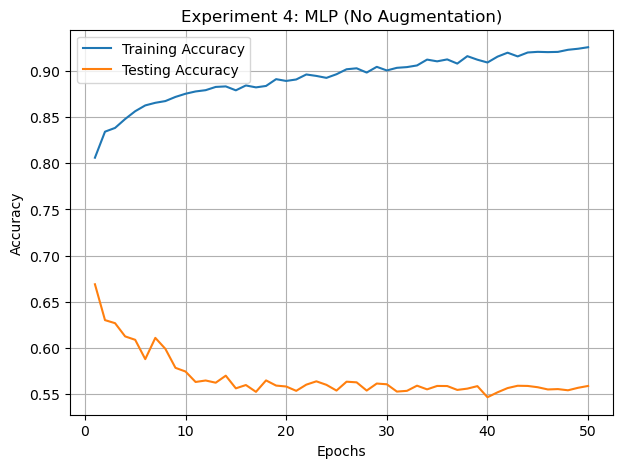

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def plot_train_test_acc(train_acc, test_acc, title):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, test_acc, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()



def compute_mean_std(dataset):
    """Compute mean and std of the dataset"""
    loader = DataLoader(dataset, batch_size=32)
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Mean over batch, height, and width, for each channel
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = torch.sqrt(channels_squared_sum / num_batches - mean**2)

    return mean, std

#load raw training dataset (without normalization) to compute stats
temp_train_dataset = datasets.FashionMNIST(root='./data',train=True,download=True,transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
train_mean, train_std = compute_mean_std(temp_train_dataset)

#define transforms with normalization using training stats
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=train_mean, std=train_std),
    #uncomment for data augmentation
    #v2.RandomApply(transforms=[v2.RandomCrop(size=(28, 28))], p=0.5),
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomApply(transforms=[v2.RandomRotation(degrees=(0, 180))], p=0.5)
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=train_mean, std=train_std)
])

#load full datasets with transforms
full_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

train_dataset = full_train_dataset

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


#convert to numpy for MLP training (flatten images)
def dataset_to_numpy(dataset):
    """convert PyTorch dataset to numpy arrays"""
    images_list = []
    labels_list = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    for images, labels in loader:
        #flatten images from (batch, 1, 28, 28) to (batch, 784)
        images = images.view(images.size(0), -1)
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    X = np.concatenate(images_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

X_train, y_train = dataset_to_numpy(train_dataset)
#X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

#activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def leaky_relu(x, gamma=0.01):
    return np.maximum(0, x) + gamma * np.minimum(0, x)

def leaky_relu_grad(x, gamma=0.01):
    grad = np.ones_like(x)
    grad[x < 0] = gamma
    return grad

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1 - np.tanh(x) ** 2

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    """
    y_pred: (batch_size, num_classes)
    y_true: (batch_size,)
    """
    n = y_true.shape[0]
    #convert labels to one-hot encoding
    y_one_hot = np.zeros_like(y_pred)
    y_one_hot[np.arange(n), y_true] = 1
    #compute cross-entropy loss
    loss = -np.sum(y_one_hot * np.log(y_pred + 1e-8)) / n
    return loss

class MLP:
    def __init__(self, h, depth, m, gamma=0.01, l1 = False, l2 = False):
        """
        h: activation function
        depth: number of hidden layers
        m: number of units per hidden layer
        gamma: parameter for leaky_relu
        """
        self.h = h
        self.depth = depth
        self.m = m
        self.gamma = gamma
        self.add_l1 = l1
        self.add_l2 = l2

        #determine activation gradient function
        if h == relu:
            self.h_grad = relu_grad
        elif h == leaky_relu:
            self.h_grad = lambda x: leaky_relu_grad(x, gamma)
        elif h == tanh:
            self.h_grad = tanh_grad
        else:
            raise ValueError("Unknown activation function")

        #initialize weights and biases
        self.weights = []
        self.biases = []

        #determine initialization scale
        def get_init_scale(n_in, n_out):
            if h == relu or h == leaky_relu:
                return np.sqrt(2 / n_in)  #He initialization
            else:  #tanh
                return np.sqrt(1 / (n_in + n_out))  #Xavier initialization

        #input to first hidden layer
        n_in = 784
        if depth == 0:
            n_out = 10
            scale = np.sqrt(1 / (n_in + n_out))  # Xavier for output layer
            self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
            self.biases.append(np.zeros((1, n_out)))
        else:
            #first hidden layer
            n_out = m
            scale = get_init_scale(n_in, n_out)
            self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
            self.biases.append(np.zeros((1, n_out)))

            #init additional hidden layers
            for i in range(depth - 1):
                n_in = m
                n_out = m
                scale = get_init_scale(n_in, n_out)
                self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
                self.biases.append(np.zeros((1, n_out)))

            #init output layer
            n_in = m
            n_out = 10
            scale = np.sqrt(1 / (n_in + n_out))  # Xavier for softmax output
            self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
            self.biases.append(np.zeros((1, n_out)))

    def forward(self, x):
        """
        Forward pass through the network
        x: (batch_size, 784)
        Returns: predictions (batch_size, 10), cache for backprop
        """
        cache = {'activations': [x], 'pre_activations': []}

        a = x
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            cache['pre_activations'].append(z)

            if self.h == leaky_relu:
                a = self.h(z, self.gamma)
            else:
                a = self.h(z)
            cache['activations'].append(a)

        #output layer with softmax
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        cache['pre_activations'].append(z)
        y_pred = softmax(z)
        cache['activations'].append(y_pred)

        return y_pred, cache

    def backward(self, y_pred, y_true, cache, reg_coeff):
        """
        Backward pass to compute gradients
        y_pred: (batch_size, 10)
        y_true: (batch_size,)
        cache: forward pass cache
        """
        n = y_true.shape[0]

        #convert labels to one-hot
        y_one_hot = np.zeros_like(y_pred)
        y_one_hot[np.arange(n), y_true] = 1

        dz = (y_pred - y_one_hot) / n

        grads_w = []
        grads_b = []

        # Backprop through layers in reverse
        for i in range(len(self.weights) - 1, -1, -1):
            #gradient of weights and biases
            a_prev = cache['activations'][i]
            dw = np.dot(a_prev.T, dz)
            db = np.sum(dz, axis=0, keepdims=True)

            if self.add_l2:
                grads_w.insert(0, dw + reg_coeff * self.weights[i])
            elif self.add_l1:
                grads_w.insert(0, dw + reg_coeff * np.sign(self.weights[i]))
            else:
                grads_w.insert(0, dw)

            grads_b.insert(0, db)

            #gradient of previous layer activation
            if i > 0:
                da = np.dot(dz, self.weights[i].T)
                #gradient through activation function
                z_prev = cache['pre_activations'][i - 1]
                dz = da * self.h_grad(z_prev)



        return grads_w, grads_b

    def fit(self, X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=100, batch_size=64, reg_coeff=0):
        """
        Train the MLP using mini-batch gradient descent
        """
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size

        train_losses = []
        train_accuracies = []
        test_accuracies = []

        for epoch in range(epochs):
            #shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            epoch_loss = 0

            #mini-batch gradient descent
            for batch in range(n_batches):
                start = batch * batch_size
                end = start + batch_size

                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Forward pass
                y_pred, cache = self.forward(X_batch)

                #compute loss
                loss = cross_entropy_loss(y_pred, y_batch)
                epoch_loss += loss

                #backward pass
                grads_w, grads_b = self.backward(y_pred, y_batch, cache, reg_coeff)

                #update weights and biases
                for i in range(len(self.weights)):
                    self.weights[i] -= learning_rate * grads_w[i]
                    self.biases[i] -= learning_rate * grads_b[i]

            #average loss over batches
            epoch_loss /= n_batches
            train_losses.append(epoch_loss)

            yh = self.predict(X_train)
            train_acc = self.evaluate_acc(y_train,yh)
            train_accuracies.append(train_acc)

            #test/validation
            yh = self.predict(X_test)
            test_acc = self.evaluate_acc(y_test,yh)
            test_accuracies.append(test_acc)

        return train_losses, train_accuracies, test_accuracies

    def predict(self, X):
        """
        Make predictions and compute accuracy
        X: (n_samples, 784)
        y: (n_samples,) - true labels
        Returns: accuracy
        """
        yh, _ = self.forward(X)
        return yh

    def evaluate_acc(self,y,yh):
        predictions = np.argmax(yh, axis=1)
        accuracy = np.mean(predictions == y)
        return accuracy

def cross_validation_split(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

def kfold_cross_val(x , y, n_folds , model, lr, n_epoches, reg_coeff):
    score_val = np.zeros(n_folds)
    for f, (tr, val) in enumerate(cross_validation_split(x.shape[0], n_folds)):
        train_losses, train_accuracies, test_accuracies = model.fit(x[tr], y[tr], x[val], y[val], learning_rate=lr, epochs=n_epoches, reg_coeff=reg_coeff)
        score_val[f] = model.evaluate_acc(y[val], model.predict(x[val]))
    return score_val, score_val.mean()

model = MLP(relu,2,256)
train_losses, val_losses, val_accuracies = model.fit(X_train, y_train, X_test, y_test,learning_rate=0.01,epochs=50,batch_size=64)
yh = model.predict(X_test)
yh_train = model.predict(X_train)
accuracy = model.evaluate_acc(y_test, yh)
print(f"\nFinal Test Accuracy: {accuracy:.4f} for model with {model.depth} hidden layers and {model.m} hidden units per layer")
accuracy = model.evaluate_acc(y_train, yh_train)
print(f"\nTraining set Accuracy: {accuracy:.4f}")

plot_train_test_acc(val_losses, val_accuracies,
                    "Experiment 4: MLP (No Augmentation)")




     

Plot for Exp 5

Train set size: 60000
Test set size: 10000
X_train: (240000, 784)
X_test: (10000, 784)

Final Test Accuracy: 0.8288 for model with 2 hidden layers and 256 hidden units per layer

Training set Accuracy: 0.9296


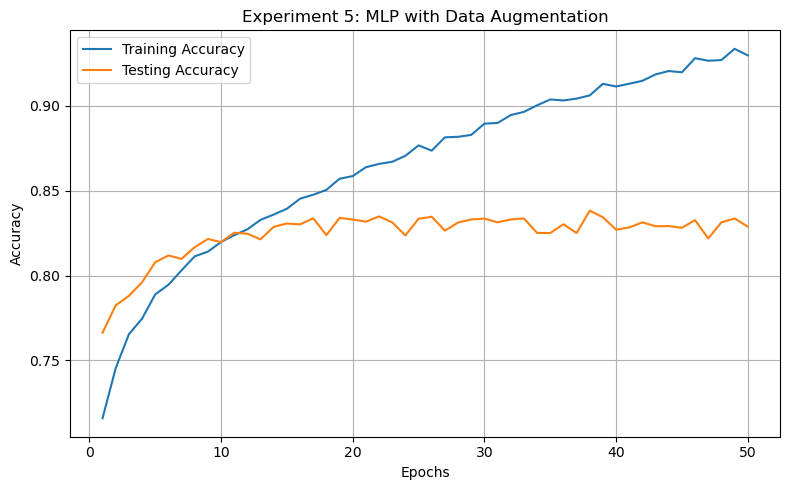

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def compute_mean_std(dataset):
    """Compute mean and std of the dataset"""
    loader = DataLoader(dataset, batch_size=32)
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Mean over batch, height, and width, for each channel
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = torch.sqrt(channels_squared_sum / num_batches - mean**2)

    return mean, std

#load raw training dataset (without normalization) to compute stats
temp_train_dataset = datasets.FashionMNIST(root='./data',train=True,download=True,transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
train_mean, train_std = compute_mean_std(temp_train_dataset)

#define transforms with normalization using training stats
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=train_mean, std=train_std),
    #data augmentation
    v2.RandomCrop(size=(28, 28), padding=4),
    v2.RandomRotation(degrees=(-10, 10)),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=train_mean, std=train_std)
])

#load full datasets with transforms
full_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

train_dataset = full_train_dataset

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


#convert to numpy for MLP training (flatten images)
def dataset_to_numpy(dataset):
    """convert PyTorch dataset to numpy arrays"""
    images_list = []
    labels_list = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    for images, labels in loader:
        #flatten images from (batch, 1, 28, 28) to (batch, 784)
        images = images.view(images.size(0), -1)
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    X = np.concatenate(images_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

X_train_list, y_train_list = [], []

#data augmentation, 4 times the data so now we have 240 000 images!
for _ in range(4):
    X, y = dataset_to_numpy(train_dataset)
    X_train_list.append(X)
    y_train_list.append(y)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test, y_test = dataset_to_numpy(test_dataset)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

#activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def leaky_relu(x, gamma=0.01):
    return np.maximum(0, x) + gamma * np.minimum(0, x)

def leaky_relu_grad(x, gamma=0.01):
    grad = np.ones_like(x)
    grad[x < 0] = gamma
    return grad

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1 - np.tanh(x) ** 2

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    """
    y_pred: (batch_size, num_classes)
    y_true: (batch_size,)
    """
    n = y_true.shape[0]
    #convert labels to one-hot encoding
    y_one_hot = np.zeros_like(y_pred)
    y_one_hot[np.arange(n), y_true] = 1
    #compute cross-entropy loss
    loss = -np.sum(y_one_hot * np.log(y_pred + 1e-8)) / n
    return loss

class MLP:
    def __init__(self, h, depth, m, gamma=0.01, l1 = False, l2 = False):
        """
        h: activation function
        depth: number of hidden layers
        m: number of units per hidden layer
        gamma: parameter for leaky_relu
        """
        self.h = h
        self.depth = depth
        self.m = m
        self.gamma = gamma
        self.add_l1 = l1
        self.add_l2 = l2

        #determine activation gradient function
        if h == relu:
            self.h_grad = relu_grad
        elif h == leaky_relu:
            self.h_grad = lambda x: leaky_relu_grad(x, gamma)
        elif h == tanh:
            self.h_grad = tanh_grad
        else:
            raise ValueError("Unknown activation function")

        #initialize weights and biases
        self.weights = []
        self.biases = []

        #determine initialization scale
        def get_init_scale(n_in, n_out):
            if h == relu or h == leaky_relu:
                return np.sqrt(2 / n_in)  #He initialization
            else:  #tanh
                return np.sqrt(1 / (n_in + n_out))  #Xavier initialization

        #input to first hidden layer
        n_in = 784
        if depth == 0:
            n_out = 10
            scale = np.sqrt(1 / (n_in + n_out))  # Xavier for output layer
            self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
            self.biases.append(np.zeros((1, n_out)))
        else:
            #first hidden layer
            n_out = m
            scale = get_init_scale(n_in, n_out)
            self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
            self.biases.append(np.zeros((1, n_out)))

            #init additional hidden layers
            for i in range(depth - 1):
                n_in = m
                n_out = m
                scale = get_init_scale(n_in, n_out)
                self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
                self.biases.append(np.zeros((1, n_out)))

            #init output layer
            n_in = m
            n_out = 10
            scale = np.sqrt(1 / (n_in + n_out))  # Xavier for softmax output
            self.weights.append(np.random.normal(0, scale, size=(n_in, n_out)))
            self.biases.append(np.zeros((1, n_out)))

    def forward(self, x):
        """
        Forward pass through the network
        x: (batch_size, 784)
        Returns: predictions (batch_size, 10), cache for backprop
        """
        cache = {'activations': [x], 'pre_activations': []}

        a = x
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            cache['pre_activations'].append(z)

            if self.h == leaky_relu:
                a = self.h(z, self.gamma)
            else:
                a = self.h(z)
            cache['activations'].append(a)

        #output layer with softmax
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        cache['pre_activations'].append(z)
        y_pred = softmax(z)
        cache['activations'].append(y_pred)

        return y_pred, cache

    def backward(self, y_pred, y_true, cache, reg_coeff):
        """
        Backward pass to compute gradients
        y_pred: (batch_size, 10)
        y_true: (batch_size,)
        cache: forward pass cache
        """
        n = y_true.shape[0]

        #convert labels to one-hot
        y_one_hot = np.zeros_like(y_pred)
        y_one_hot[np.arange(n), y_true] = 1

        dz = (y_pred - y_one_hot) / n

        grads_w = []
        grads_b = []

        # Backprop through layers in reverse
        for i in range(len(self.weights) - 1, -1, -1):
            #gradient of weights and biases
            a_prev = cache['activations'][i]
            dw = np.dot(a_prev.T, dz)
            db = np.sum(dz, axis=0, keepdims=True)

            if self.add_l2:
                grads_w.insert(0, dw + reg_coeff * self.weights[i])
            elif self.add_l1:
                grads_w.insert(0, dw + reg_coeff * np.sign(self.weights[i]))
            else:
                grads_w.insert(0, dw)

            grads_b.insert(0, db)

            #gradient of previous layer activation
            if i > 0:
                da = np.dot(dz, self.weights[i].T)
                #gradient through activation function
                z_prev = cache['pre_activations'][i - 1]
                dz = da * self.h_grad(z_prev)



        return grads_w, grads_b

    def fit(self, X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=100, batch_size=64, reg_coeff=0):
        """
        Train the MLP using mini-batch gradient descent
        """
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size

        train_losses = []
        train_accuracies = []
        test_accuracies = []

        for epoch in range(epochs):
            #shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            epoch_loss = 0

            #mini-batch gradient descent
            for batch in range(n_batches):
                start = batch * batch_size
                end = start + batch_size

                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Forward pass
                y_pred, cache = self.forward(X_batch)

                #compute loss
                loss = cross_entropy_loss(y_pred, y_batch)
                epoch_loss += loss

                #backward pass
                grads_w, grads_b = self.backward(y_pred, y_batch, cache, reg_coeff)

                #update weights and biases
                for i in range(len(self.weights)):
                    self.weights[i] -= learning_rate * grads_w[i]
                    self.biases[i] -= learning_rate * grads_b[i]

            #average loss over batches
            epoch_loss /= n_batches
            train_losses.append(epoch_loss)

            yh = self.predict(X_train)
            train_acc = self.evaluate_acc(y_train,yh)
            train_accuracies.append(train_acc)

            #test/validation
            yh = self.predict(X_test)
            test_acc = self.evaluate_acc(y_test,yh)
            test_accuracies.append(test_acc)

        return train_losses, train_accuracies, test_accuracies

    def predict(self, X):
        """
        Make predictions and compute accuracy
        X: (n_samples, 784)
        y: (n_samples,) - true labels
        Returns: accuracy
        """
        yh, _ = self.forward(X)
        return yh

    def evaluate_acc(self,y,yh):
        predictions = np.argmax(yh, axis=1)
        accuracy = np.mean(predictions == y)
        return accuracy

def cross_validation_split(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

def kfold_cross_val(x , y, n_folds , model, lr, n_epoches, reg_coeff):
    score_val = np.zeros(n_folds)
    for f, (tr, val) in enumerate(cross_validation_split(x.shape[0], n_folds)):
        train_losses, train_accuracies, test_accuracies = model.fit(x[tr], y[tr], x[val], y[val], learning_rate=lr, epochs=n_epoches, reg_coeff=reg_coeff)
        score_val[f] = model.evaluate_acc(y[val], model.predict(x[val]))
    return score_val, score_val.mean()

model = MLP(relu,2,256)
train_losses, train_accuracies, test_accuracies = model.fit(X_train, y_train, X_test, y_test,learning_rate=0.01,epochs=50,batch_size=64)
yh = model.predict(X_test)
yh_train = model.predict(X_train)
accuracy = model.evaluate_acc(y_test, yh)
print(f"\nFinal Test Accuracy: {accuracy:.4f} for model with {model.depth} hidden layers and {model.m} hidden units per layer")
accuracy = model.evaluate_acc(y_train, yh_train)
print(f"\nTraining set Accuracy: {accuracy:.4f}")

epochs = np.arange(1, len(train_accuracies) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, test_accuracies, label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Experiment 5: MLP with Data Augmentation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plot for Exp 6

100%|█████████████████████████████████████████| 938/938 [00:27<00:00, 33.57it/s]


Epoch 1, Loss: 397.8200, Accuracy: 84.60%
Epoch 1, Test Acc: 0.8876


100%|█████████████████████████████████████████| 938/938 [00:27<00:00, 33.74it/s]


Epoch 2, Loss: 259.2949, Accuracy: 89.88%
Epoch 2, Test Acc: 0.8868


100%|█████████████████████████████████████████| 938/938 [00:27<00:00, 33.69it/s]


Epoch 3, Loss: 214.8172, Accuracy: 91.70%
Epoch 3, Test Acc: 0.9114


100%|█████████████████████████████████████████| 938/938 [00:26<00:00, 35.15it/s]


Epoch 4, Loss: 185.5602, Accuracy: 92.75%
Epoch 4, Test Acc: 0.9193


100%|█████████████████████████████████████████| 938/938 [00:27<00:00, 34.22it/s]


Epoch 5, Loss: 162.9576, Accuracy: 93.56%
Epoch 5, Test Acc: 0.9181

Final Test Accuracy: 0.9181


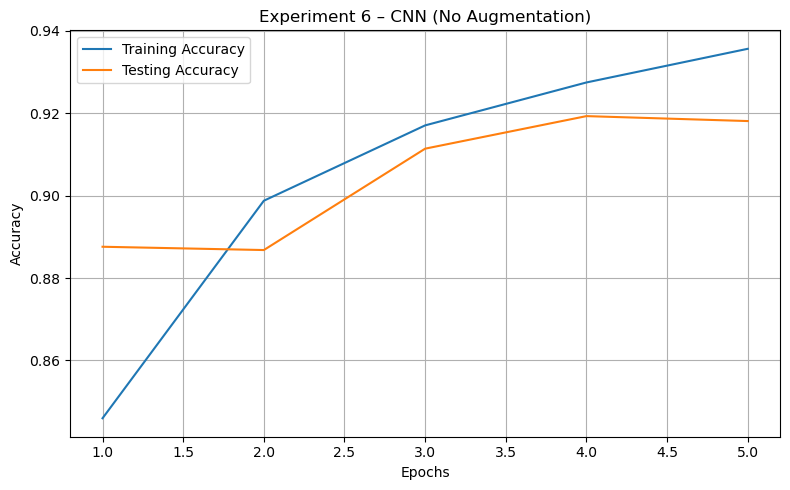

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def compute_mean_std(dataset):
    """Compute mean and std of the dataset"""
    loader = DataLoader(dataset, batch_size=32)
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Mean over batch, height, and width, for each channel
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = torch.sqrt(channels_squared_sum / num_batches - mean**2)

    return mean, std

#load raw training dataset (without normalization) to compute stats
temp_train_dataset = datasets.FashionMNIST(root='./data',train=True,download=True,transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
train_mean, train_std = compute_mean_std(temp_train_dataset)

#define transforms with normalization using training stats
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=train_mean, std=train_std),
    #uncomment for data augmentation
    #v2.RandomApply(transforms=[v2.RandomCrop(size=(28, 28))], p=0.5),
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomApply(transforms=[v2.RandomRotation(degrees=(0, 180))], p=0.5)
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=train_mean, std=train_std)
])

#load full datasets with transforms
full_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)
train_dataset = full_train_dataset

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Changed from 128
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

learning_rate = 1e-3
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_accuracies = []
test_accuracies = []


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)


         
    train_acc = correct / total                      
    train_accuracies.append(train_acc)           

    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.2%}")

    
    model.eval()                                      
    correct_test = 0                               
    total_test = 0                                  
    with torch.no_grad():                             
        for images, labels in test_loader:            
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)                  
            preds = torch.argmax(outputs, dim=1)      
            correct_test += (preds == labels).sum().item()  
            total_test += len(preds)                  

    test_acc = correct_test / total_test              
    test_accuracies.append(test_acc)                  
    print(f"Epoch {epoch + 1}, Test Acc: {test_acc:.4f}")  
    

#evaluate on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += len(preds)

print(f"\nFinal Test Accuracy: {correct/total:.4f}")


epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, test_accuracies, label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Experiment 6 – CNN (No Augmentation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plot for Exp 7